In [12]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sps
from scipy.sparse import linalg
import scipy.sparse.linalg 

In [13]:
def nestdiff(n):
    a = (np.array([np.arange(1,n**2+1)]).reshape(n,n)).astype(int)
    N = n**2
    a = a[::-1]
    b = np.zeros((n,n), dtype=int) 
    
    k = int(np.floor(n/2))  # middle column 
    b[:,k] = np.hstack([np.arange(N,N-n,-1)])
    lt1 = int((N-n)/(n-1)) * k #(N-n)/2
    
    sr1 = 0 #starting point where we insert T: starting row for T1
    sc1 = 0 # start column
    sr2 = 0 #starting point where we insert T (in this case to the right of center column in b)
    sc2 = k+1
    #size of each element inside T
    nr1 = n
    nr2 = n
    nc1 = k
    nc2 = n-k-1
    min1 = 1
    max1 = lt1
    min2 = lt1+1
    max2 = N-n
    mt = np.array([[nr1,nc1,min1,max1,sr1,sc1],[nr2,nc2,min2,max2,sr2,sc2]], dtype=int) 
   
    while(len(b[b>0]) < n**2): # filling the left side of b #(n**2 - T2.shape[0] * T2.shape[1] )     #n**2):
    
        b,mt = split(b,mt)

    p = np.zeros(n**2, dtype=int)    
    for i in range(n):
        for j in range(n):
            p[b[i,j]-1] = a[i,j]
    
    return p

In [14]:
def split(b,mt1):
    #this matrix has all info about elements matrix T
    # mt1 = np.array([[nr1,nc1,min1,max1,str1,stc1],[nr2,nc2,min2,max2,str2,stc2]], dtype=int)   
    elem = mt1.shape[0]
    # mt is updated mt1
    mt = np.zeros((0,6), dtype=int)   
    for j in range(elem):
        #print('j=',j)
        n = mt1[j,0]
        m = mt1[j,1]
        # one d array of all elements in T[j]
        p = np.array([np.arange(mt1[j,2],mt1[j,3]+1)], dtype=int)
        if(n>m or n==m):
            mid = int(np.floor(n/2))
            #middle row or column which has highest values
            tm = np.array((m), dtype=int)
            t = np.zeros((0,m), dtype=int)
            t2min = mt1[j,2]
            t2max = (n-mid-1)*m-1 + t2min
            t1min = t2max + 1
            t1max = mid*m-1 + t1min
            t1 = np.array([np.arange(t1min,t1max+1)])
            t1 = t1.reshape(mid,m)
            t1 = t1[::-1]
            
            t2 = np.array([np.arange(t2min,t2max+1)])
            t2 = t2.reshape(n-mid-1,m)
            t2 = t2[::-1]
            tm = p[0,m*n-m:]

            t = np.append(t, t1, axis=0) 
            t = np.append(t, t2, axis=0)
            t = np.insert(t, mid, tm, axis=0)
        # m>n
        else:
            mid = int(np.floor(m/2))
            tm = np.array((n), dtype=int)
            t = np.zeros((n,0), dtype=int)
            t2min = mt1[j,2]
            t2max = n*(m-mid-1)-1 + t2min
            t1min = t2max + 1
            t1max = n*mid-1 + t1min
            
            t1 = np.array([np.arange(t1min,t1max+1)])
            t1 = t1.reshape(n,mid)
            t1 = t1[::-1]
        
            t2 = np.array([np.arange(t2min,t2max+1)])
            t2 = t2.reshape(n,m-mid-1)
            t2 = t2[::-1]
            tm = p[0,m*n-n:]
           
            t = np.append(t, t1, axis=1)
            t = np.append(t, t2, axis=1)
            t = np.insert(t, mid, tm, axis=1)
        #
        t1n = t1.shape[0]
        t1m = t1.shape[1]
        t2n = t2.shape[0]
        t2m = t2.shape[1]        
        # shape of t1 and t2 smaller than 3x3, update b with whole t
        if((n<= 3 and m<=3) or (m<= 5 and n<=2) or (n<=5 and m<=2)):
            # start_end of each element in T
            b[mt1[j,4]:mt1[j,4]+n,mt1[j,5]:mt1[j,5]+m] = t
        elif((t2n <3 and t2m <3)):
            b[mt1[j,4]:mt1[j,4]+n,mt1[j,5]:mt1[j,5]+m] = t 
        
        # add when t2 1 row or 1 column
        elif(t2n ==1 or t2m ==1):
            if(n>m or n==m):
            #if(t2n>t2m):
                b[mt1[j,4]+t1n:mt1[j,4]+t1n+2,mt1[j,5]:mt1[j,5]+t2m] = t[n-2:n,:]
            else: # m > n
                b[mt1[j,4]:mt1[j,4]+n,mt1[j,5]+t1m:mt1[j,5]+m] = t[:,m-2:m]
        else:
            if(n>m or n==m):
                b[mt1[j,4]+mid,mt1[j,5]:mt1[j,5]+m] = t[mid,:]
            # m>n
            else:
                b[mt1[j,4]:mt1[j,4]+n,mt1[j,5]+mid] = t[:,mid]
        #add to mt list if size less than or equal 2x3
        if((t1n >=2 and t1m >=3) or (t1n>=3 and t1m>=2)):
            #[nr1,nc1,min1,max1,sr1,sc1]
            min1 = np.min(t1.flatten())
            max1 = np.max(t1.flatten())
            nr1 = t1n
            nc1 = t1m
            sr1 = mt1[j,4]
            sc1 = mt1[j,5]
            mt = np.append(mt, [[nr1,nc1,min1,max1,sr1,sc1]], axis=0)
        
        if((t2n >=2 and t2m >=3) or (t2n>=3 and t2m>=2)):
            min2 = np.min(t2.flatten())
            max2 = np.max(t2.flatten())
            nr2 = t2n
            nc2 = t2m
            if(n>m or n==m):
                sr2 = mt1[j,4]+t1n+1
                sc2 = mt1[j,5] 
            # m>n
            else:
                sr2 = mt1[j,4]
                sc2 = mt1[j,5]+t1m+1
            mt = np.append(mt, [[nr2,nc2,min2,max2,sr2,sc2]], axis=0)
        
    return b,mt

In [15]:
def sparse_A(n):
    h = 1.0 / (n + 1)
    e = np.ones((n))
    #A = sps.lil_matrix((n**2,n**2))
    A1 = sps.spdiags(np.vstack([-e, 2*e, -e]),
                               [-1, 0, 1], n, n)
    I = sps.eye(n, n)
    A = sps.kron(A1, I) + sps.kron(I, A1)
    f = h**2 * np.ones((n**2))
    return A, f

## a. natural ordering

In [16]:
n = np.array([10,20,40,80,160,320] ,dtype=int)
ln = len(n)
nz = np.zeros((3,ln))

In [17]:
for i in range(ln):
    A,f = sparse_A(n[i])
    A2 = sps.linalg.splu(A.tocsc(), 'natural')
    nz[0,i] = np.count_nonzero(A2.U.tocoo().row) + np.count_nonzero(A2.L.tocoo().row)

## b. Approximate minimum degree (colamd)

In [18]:
for i in range(ln):
    A,f = sparse_A(n[i])
    A2 = sps.linalg.splu(A.tocsc())
    nz[1,i] = np.count_nonzero(A2.U.tocoo().row) + np.count_nonzero(A2.L.tocoo().row)

## c. nestdiff

In [19]:
for i in range(ln):
    A,f = sparse_A(n[i])
    p = nestdiff(n[i])
    A2 = sps.lil_matrix(A.shape)
    A2[:,:] = A[:,p-1]
    A3 = sps.linalg.splu(A2, 'natural')
    nz[2,i] = np.count_nonzero(A3.U.tocoo().row) + np.count_nonzero(A3.L.tocoo().row)

In [20]:
print('non zeros:')
print(nz)

non zeros:
[[  2.01400000e+03   1.60340000e+04   1.28074000e+05   1.02415400e+06
    8.19231400e+06   6.55366340e+07]
 [  1.52200000e+03   1.00420000e+04   6.48960000e+04   3.70276000e+05
    2.03655600e+06   1.03274360e+07]
 [  1.58300000e+03   9.77500000e+03   5.65350000e+04   3.06635000e+05
    1.57767100e+06   7.78968300e+06]]


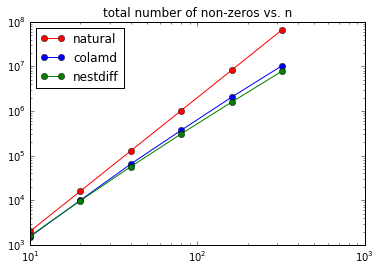

In [21]:
plt.title('total number of non-zeros vs. n')
L1,=plt.loglog(n[:],nz[0,:],'r',label='natural',lw=1,marker='o')
L2,=plt.loglog(n[:],nz[1,:],'b',label='colamd',lw=1,marker='o')
L3,=plt.loglog(n[:],nz[2,:],'g',label='nestdiff',lw=1,marker='o')
Leg1=plt.legend(handles=[L1,L2,L3],loc=2)
plt.show()

In [22]:
slope1, intercept = np.polyfit(np.log(n[:]),np.log(nz[0,:]),1)
slope2, intercept = np.polyfit(np.log(n[:]),np.log(nz[1,:]),1)
slope3, intercept = np.polyfit(np.log(n[:]),np.log(nz[2,:]),1)
print('alpha for natural case:', slope1)
print('alpha for colamd case:', slope2)
print('alpha for nestdiff case:', slope3)

alpha for natural case: 2.99828894203
alpha for colamd case: 2.54701009761
alpha for nestdiff case: 2.45046275196
